# Modelling tabular data
> After completing the data retrieval and cleaning we here deal with how to set up basic models.

In [ ]:
#default_exp modelling

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
import pandas as pd
from fastai2.tabular.all import *
from fastai2 import metrics
from sklearn import ensemble
import pickle
from typing import List
from kaggle_house_prices.utils import *
from kaggle_house_prices.preprocessing import *

## Setting up the `TabularDataLoader`

The data loader is required to feed data into the learner during training

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
# df_s = pd.read_csv(clean_data_path, encoding="utf8")

In [ ]:
df_s = pd.read_feather(clean_data_path_feather).set_index("index")

In [ ]:
#hide
display_all(df_s.head().T)

index,939,921,1,603,1453
Id,940,922,2,604,1454
MSSubClass,70,90,20,160,20
MSZoning,RL,RL,RL,FV,RL
LotFrontage,69,67,80,30,90
LotArea,24090,8777,9600,3182,17217
Street,Pave,Pave,Pave,Pave,Pave
Alley,NA,NA,NA,Pave,NA
LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


Transforming `dep_var` to log space

In [ ]:
if df_s[dep_var].dtype != "float64":
    df_s[dep_var] = df_s[dep_var].apply(float)

Get `splits` object for `TabularPandas`

In [ ]:
splits = ColSplitter(col="valid")(df_s)

Set up the [`TabularPandas`](https://dev.fast.ai/tabular.core#TabularPandas) object

In [ ]:
to = TabularPandas(df_s, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=dep_var, splits=splits)

In [ ]:
#hide
display_all(df_s.iloc[splits[1]][cat_names].head())

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotArea_na,YearBuilt_na,YearRemodAdd_na,MasVnrArea_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,1stFlrSF_na,2ndFlrSF_na,GrLivArea_na,GarageYrBlt_na,GarageArea_na,WoodDeckSF_na,OpenPorchSF_na,LotFrontage_na,BsmtFinSF1_na,LowQualFinSF_na
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103,104,20,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,3,1,Gd,6,Typ,0,NA,Attchd,RFn,3,TA,TA,Y,0,0,0,0,NA,NA,NA,0,5,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
915,916,160,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Fa,Y,SBrkr,0,0,1,1,3,1,TA,6,Typ,0,NA,Attchd,Unf,1,TA,TA,Y,0,0,0,0,NA,NA,NA,0,1,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1284,1285,50,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,6,7,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,4,1,Gd,10,Min2,1,Gd,Detchd,Unf,1,TA,TA,Y,42,0,116,0,NA,NA,NA,0,3,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1309,1310,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,6,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,1,0,2,0,3,1,Gd,6,Typ,0,NA,Attchd,RFn,2,TA,TA,Y,0,0,0,0,NA,GdWo,NA,0,6,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
525,526,20,FV,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,3,1,Gd,6,Typ,1,TA,Attchd,Unf,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,4,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
#hide
display_all(to.valid.xs[cat_names].head())

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotArea_na,YearBuilt_na,YearRemodAdd_na,MasVnrArea_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,1stFlrSF_na,2ndFlrSF_na,GrLivArea_na,GarageYrBlt_na,GarageArea_na,WoodDeckSF_na,OpenPorchSF_na,LotFrontage_na,BsmtFinSF1_na,LowQualFinSF_na
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103,104,1,4,2,2,1,4,1,1,1,6,3,3,1,3,7,5,2,2,13,14,4,4,5,3,3,5,5,7,7,2,1,2,6,1,1,3,1,4,2,3,5,7,1,4,2,3,4,6,6,3,1,1,1,1,4,5,2,1,5,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
915,916,13,5,2,2,4,4,1,5,1,11,3,3,4,6,4,5,2,2,6,6,2,4,5,2,5,5,5,7,7,2,2,2,6,1,1,2,2,4,2,4,5,7,1,4,2,4,2,6,6,3,1,1,1,1,4,5,2,1,1,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1284,1285,5,4,2,2,4,4,1,5,1,19,2,3,1,1,6,7,2,2,14,16,4,4,5,3,5,5,5,7,7,2,1,2,6,1,1,3,1,5,2,3,9,4,2,3,6,4,2,6,6,3,12,1,11,1,4,5,2,1,3,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1309,1310,1,4,2,2,4,4,1,5,1,21,3,3,1,3,6,5,2,2,7,7,2,4,5,2,3,5,5,3,7,2,3,2,6,2,1,3,1,4,2,3,5,7,1,4,2,3,3,6,6,3,1,1,1,1,4,2,2,1,6,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
525,526,1,2,2,3,4,4,1,5,1,22,3,3,1,3,7,5,2,2,13,14,4,3,5,3,3,5,5,7,7,2,1,2,6,1,1,3,1,4,2,3,5,7,2,6,2,4,3,6,6,3,1,1,1,1,4,5,2,1,4,9,5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Going over categorical mappings where `Categorify` did not make one-hot encodings sanity checking train and validation set encodings

In [ ]:
#export
def inspect_category_mappings(cat_names:List[str], df:pd.DataFrame, splits:ColSplitter, 
                              to:TabularPandas, n_max:int=None):
    "Shows unique original and transformed discrete values side by side for sanity checks"
    for i, col in enumerate(cat_names):
        print(f"\nColumn: {col}")
        _df = (pd.DataFrame({"original-train": df.iloc[splits[0]][col], "categorified-train": to.train.xs[col]})
               .drop_duplicates()
               .sort_values("categorified-train"))
        display_all(_df.head())
        _df = (pd.DataFrame({"original-valid": df.iloc[splits[1]][col], "categorified-valid": to.valid.xs[col]})
               .drop_duplicates()
               .sort_values("categorified-valid"))
        display_all(_df.head())

        if n_max is not None and i+1 == n_max:
            break

In [ ]:
inspect_category_mappings(cat_names, df_s, splits, to, n_max=1)


Column: Id


,original-train,categorified-train
index,,
1,2,2
7,8,8
14,15,15
28,29,29
56,57,57


,original-valid,categorified-valid
index,,
29,30,30
103,104,104
210,211,211
266,267,267
347,348,348


In [ ]:
#hide
display_all(df_s.iloc[splits[1]][cont_names].head())

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage,BsmtFinSF1,LowQualFinSF
index,,,,,,,,,,,,,,,,,
103,10402.0,2009.0,2009.0,0.0,0.0,1226.0,1226.0,1226.0,0.0,1226.0,2009.0,740.0,0.0,36.0,94.0,0.0,0.0
915,2001.0,1970.0,1970.0,80.0,0.0,546.0,546.0,546.0,546.0,1092.0,1970.0,286.0,0.0,0.0,21.0,0.0,0.0
1284,9638.0,1919.0,1990.0,0.0,0.0,804.0,804.0,1699.0,748.0,2447.0,1969.0,336.0,272.0,0.0,50.0,0.0,0.0
1309,7153.0,1991.0,1991.0,88.0,0.0,78.0,1278.0,1294.0,0.0,1294.0,1991.0,496.0,112.0,51.0,69.0,1200.0,0.0
525,7500.0,2005.0,2005.0,0.0,0.0,1257.0,1257.0,1266.0,0.0,1266.0,2005.0,453.0,38.0,144.0,62.0,0.0,0.0


In [ ]:
#hide
display_all(to.valid.xs[cont_names].head())

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage,BsmtFinSF1,LowQualFinSF
index,,,,,,,,,,,,,,,,,
103,0.116806,1.283469,1.182399,-0.700511,-0.277886,1.496824,0.328323,0.076563,-0.785797,-0.648692,1.320039,0.989025,-0.839184,-0.174605,0.917940,-1.194996,-0.112509
915,-1.949668,-0.121099,-0.657544,-0.145170,-0.277886,0.018587,-1.377904,-1.874271,0.458578,-0.916906,-0.375524,-0.923620,-0.839184,-0.771829,-2.292102,-1.194996,-0.112509
1284,-0.071122,-1.957842,0.286017,-0.700511,-0.277886,0.579447,-0.730541,1.433540,0.918952,1.795257,-0.419000,-0.712976,1.428092,-0.771829,-1.016880,-1.194996,-0.112509
1309,-0.682381,0.635207,0.333195,-0.089636,-0.277886,-0.998788,0.458799,0.271647,-0.785797,-0.512584,0.537472,-0.038916,0.094400,0.074238,-0.181389,1.573935,-0.112509
525,-0.597026,1.139411,0.993687,-0.700511,-0.277886,1.564214,0.406107,0.191318,-0.785797,-0.568629,1.146135,-0.220070,-0.522432,1.617066,-0.489202,-1.194996,-0.112509


In [ ]:
#hide
display_all(df_s.iloc[splits[1]][dep_var].head())

index
103     12.200557
915     11.225243
1284    12.037654
1309    12.096258
525     12.078239
Name: SalePrice, dtype: float64

In [ ]:
#hide
to.valid.ys.head()

,SalePrice
index,
103,12.200557
915,11.225243
1284,12.037654
1309,12.096258
525,12.078239


Writing `to` to disk

In [ ]:
#export
model_data_path = "model_data.pckl"

In [ ]:
with open(model_data_path, "wb") as f:
    pickle.dump(to, f)

Creating the data loader

In [ ]:
dls = to.dataloaders()

In [ ]:
#hide
dls.show_batch()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotArea_na,YearBuilt_na,YearRemodAdd_na,MasVnrArea_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,1stFlrSF_na,2ndFlrSF_na,GrLivArea_na,GarageYrBlt_na,GarageArea_na,WoodDeckSF_na,OpenPorchSF_na,LotFrontage_na,BsmtFinSF1_na,LowQualFinSF_na,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,LotFrontage,BsmtFinSF1,LowQualFinSF,SalePrice
0,63,120,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,8,5,Gable,CompShg,VinylSd,VinylSd,Stone,Gd,TA,PConc,Gd,Gd,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,RFn,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,10,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6442.000020,2006.000001,2006.000000,178.000000,0.000001,1345.999988,1370.000011,1370.000004,0.000011,1370.000005,2006.000000,484.000000,1.200000e+02,49.000000,43.999999,24.000003,6.260144e-08,12.218495
1,213,60,FV,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,7,New,Partial,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,8639.999972,2009.000000,2009.000000,-0.000002,0.000001,78.000003,900.000003,932.000003,919.999981,1852.000012,2008.999999,643.999998,1.680000e+02,108.000000,72.000000,822.000000,6.260144e-08,12.439871
2,175,20,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,6,5,Gable,CompShg,VinylSd,Plywood,Stone,TA,TA,CBlock,Gd,Fa,No,ALQ,LwQ,GasA,TA,Y,SBrkr,1,0,2,0,3,1,TA,7,Min2,1,TA,Attchd,Fin,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,11,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12415.999986,1986.000000,1986.000000,132.000000,207.999994,0.000024,1606.000022,1651.000003,0.000011,1651.000002,1986.000000,616.000003,1.920000e+02,-0.000002,46.999999,1398.000001,6.260144e-08,12.122691
3,365,60,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,TA,Y,SBrkr,1,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,Fin,2,TA,TA,Y,0,0,0,0,NA,NA,NA,0,7,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,18800.000403,1976.000000,1976.000000,120.000000,0.000001,84.000010,795.999997,790.000005,784.000012,1574.000000,1976.000000,566.000001,3.060000e+02,110.999996,69.000000,712.000003,6.260144e-08,12.154779
4,393,20,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Slab,NA,NA,NA,NA,NA,GasA,TA,Y,SBrkr,0,0,1,0,3,1,TA,5,Typ,0,NA,Attchd,RFn,1,TA,TA,Y,0,0,0,0,NA,MnPrv,Shed,1200,7,WD,Normal,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,8339.000048,1959.000001,1959.000001,-0.000002,0.000001,0.000024,-0.000016,882.000002,0.000011,882.000006,1959.000001,294.000004,-9.907507e-07,-0.000002,69.000000,-0.000022,6.260144e-08,11.575900
5,306,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,Gable,CompShg,CemntBd,CmentBd,Stone,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,0,3,1,Gd,8,Typ,0,NA,Attchd,Fin,3

## Setting up the `Learner`

The main function to set up a learner for tabular data is fastai's [`tabular_learner`](https://github.com/fastai/fastai2/blob/master/fastai2/tabular/learner.py) function, which is based on the [`Learner`](https://dev.fast.ai/learner#Learner) class.

In [ ]:
#export
def mish(x:torch.Tensor) -> torch.Tensor:
    return x * torch.tanh(F.softplus(x))

class Mish(torch.nn.Module):
    "Mish activation function: arXiv:1908.08681"
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return mish(input)

Modifying the [`TabularModel`](https://dev.fast.ai/tabular.model#TabularModel) class so it can take any non-linear activation functions

In [ ]:
#export
@patch    
def __init__(self:TabularModel, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0.,
             y_range=None, use_bn=True, bn_final=False, active_fun:nn.Module=None):
    ps = ifnone(ps, [0]*len(layers))
    if not is_listy(ps): ps = [ps]*len(layers)
    self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
    self.emb_drop = nn.Dropout(embed_p)
    self.bn_cont = nn.BatchNorm1d(n_cont)
    n_emb = sum(e.embedding_dim for e in self.embeds)
    self.n_emb,self.n_cont = n_emb,n_cont
    sizes = [n_emb + n_cont] + layers + [out_sz]
    # actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
    actns = [active_fun() for _ in range(len(sizes)-2)] + [None]
    _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn and (i!=len(actns)-1 or bn_final), p=p, act=a)
                   for i,(p,a) in enumerate(zip(ps+[0.],actns))]
    if y_range is not None: _layers.append(SigmoidRange(*y_range))
    self.layers = nn.Sequential(*_layers)

Defining the loss function

In [ ]:
loss_fun = torch.nn.functional.mse_loss

Collecting the range of `dep_var` values

In [ ]:
y_range = [min(to.valid.ys.values.min(), to.train.ys.values.min()), 
           max(to.valid.ys.values.max(), to.train.ys.values.max())]; y_range

[10.578979797857352, 12.962194625251508]

Setting up the customized tabular learner

In [ ]:
%%time
learn = tabular_learner(dls, n_out=1, loss_func=loss_fun, config=dict(active_fun=Mish),
                        y_range=y_range)

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 32.4 ms


In [ ]:
#hide
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1461, 95)
    (1): Embedding(16, 8)
    (2): Embedding(6, 4)
    (3): Embedding(3, 3)
    (4): Embedding(4, 3)
    (5): Embedding(5, 4)
    (6): Embedding(5, 4)
    (7): Embedding(3, 3)
    (8): Embedding(6, 4)
    (9): Embedding(4, 3)
    (10): Embedding(26, 10)
    (11): Embedding(10, 6)
    (12): Embedding(9, 5)
    (13): Embedding(6, 4)
    (14): Embedding(9, 5)
    (15): Embedding(11, 6)
    (16): Embedding(10, 6)
    (17): Embedding(7, 5)
    (18): Embedding(9, 5)
    (19): Embedding(16, 8)
    (20): Embedding(17, 8)
    (21): Embedding(6, 4)
    (22): Embedding(5, 4)
    (23): Embedding(6, 4)
    (24): Embedding(7, 5)
    (25): Embedding(6, 4)
    (26): Embedding(6, 4)
    (27): Embedding(6, 4)
    (28): Embedding(8, 5)
    (29): Embedding(8, 5)
    (30): Embedding(7, 5)
    (31): Embedding(6, 4)
    (32): Embedding(3, 3)
    (33): Embedding(7, 5)
    (34): Embedding(5, 4)
    (35): Embedding(4, 3)
    (36): Embedding(5, 4

Searching for a good initial maximum learning rate

CPU times: user 31.7 s, sys: 27.5 s, total: 59.2 s
Wall time: 9.35 s


(0.010000000149011612, 0.0002754228771664202)

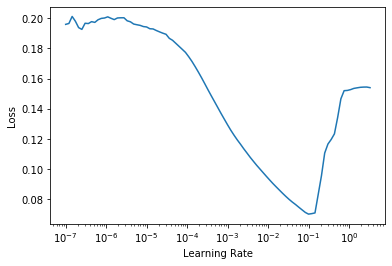

In [ ]:
%%time
learn.lr_find()

Running the following cell a few times and storing the model if it is better than the previous one

In [ ]:
%%time
# learn.fit_one_cycle(5, 5e-2)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.172832,0.193806,00:00
1,0.177824,0.186320,00:00
2,0.140937,0.178411,00:00
3,0.115761,0.172578,00:00
4,0.100377,0.169492,00:00


CPU times: user 1.89 s, sys: 1.86 s, total: 3.75 s
Wall time: 607 ms


In [ ]:
learn.save("model-1")

CPU times: user 26.5 s, sys: 22.2 s, total: 48.7 s
Wall time: 7.48 s


(0.006918309628963471, 2.5118865210060903e-07)

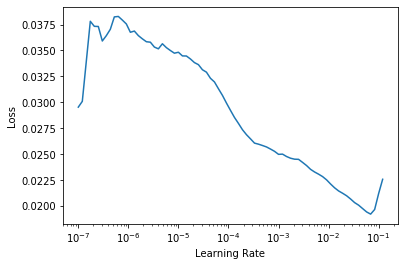

In [ ]:
%%time
learn.lr_find()

In [ ]:
#hide
learn.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,time
0,0.033687,0.167675,00:00
1,0.033218,0.164674,00:00
2,0.029728,0.162344,00:00
3,0.026271,0.160309,00:00
4,0.022700,0.158340,00:00


In [ ]:
#hide
learn.save("model-2")

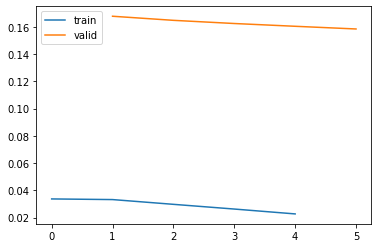

In [ ]:
learn.recorder.plot_loss(skip_start=0)

In [ ]:
#hide
learn.save("model-final")

Collecting predictions, `y_pred`, and ground truth, `y_true`, for all observations to approximate Kaggle's model evaluation.

In [ ]:
y_pred, y_true = learn.get_preds()

y_pred[:5], y_true[:5]

(tensor([[11.8757],
         [11.7815],
         [11.8422],
         [11.8395],
         [11.8636]]),
 tensor([[12.2006],
         [11.2252],
         [12.0377],
         [12.0963],
         [12.0782]]))

In [ ]:
#export
def predictions_vs_true_distribution_plots(y_pred:torch.Tensor, y_true:torch.Tensor, dep_var:str, bins:int=50):
    "Plots the predicted and true distributions side by side plus the residuals distribution"
    _y_p = y_pred.detach().numpy().ravel()
    _y_t = y_true.detach().numpy().ravel()

    fig, axs = plt.subplots(ncols=2, figsize=(14,4))
    ax = axs[0]
    ax.hist(_y_p, bins=bins, alpha=.5, label="pred")
    ax.hist(_y_t, bins=bins, alpha=.5, label="true")
    ax.set_xlabel(f"{dep_var}")
    ax.set_title(f"predicted vs true '{dep_var}'")
    ax.legend()

    ax = axs[1]
    ax.hist(_y_p-_y_t, bins=bins)
    ax.set_xlabel("Δ")
    ax.set_title(f"Δ-distribution: mean = {(_y_p-_y_t).mean():.2f}, std = {np.std(_y_p-_y_t):.2f}")
    plt.show()

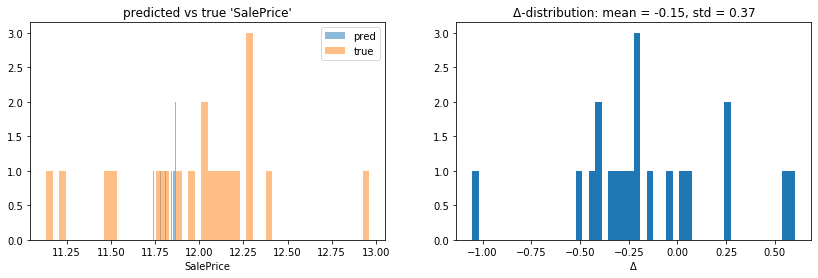

CPU times: user 469 ms, sys: 0 ns, total: 469 ms
Wall time: 493 ms


In [ ]:
%%time
predictions_vs_true_distribution_plots(y_pred, y_true, dep_var, bins=50)

Score of the current model predictions vs compared to the public leaderboard

,TeamId,TeamName,SubmissionDate,Score
7590,4210573,hsuanpingsun,2020-01-04 03:44:55,0.0
10044,4278029,Muhammet İkbal Elek,2020-01-20 13:09:34,0.0
9856,3740535,wentixiaogege,2020-01-19 03:37:57,0.0
4988,4155989,terracoda,2019-12-20 12:56:53,0.0
15086,2248598,predictor!,2020-02-15 13:51:49,0.0


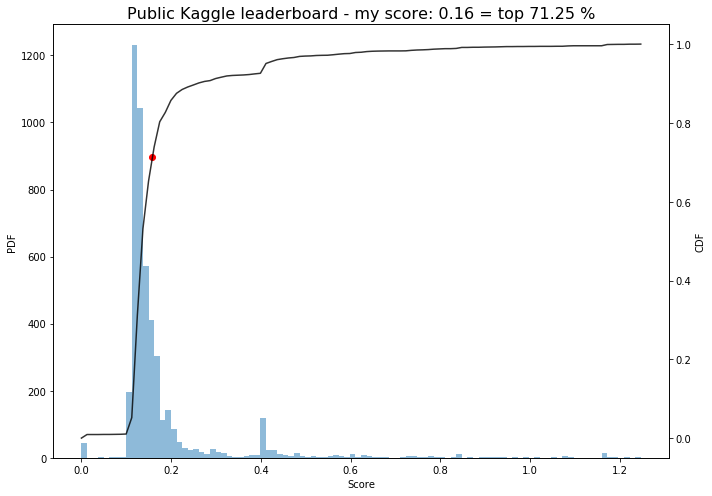

In [ ]:
my_score = loss_fun(y_pred, y_true).item()

show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, user_score=my_score, user="my")

In [ ]:
assert my_score < .25

In [ ]:
#hide
ens = ensemble.RandomForestRegressor(n_estimators=100, max_features="sqrt", max_samples=.9, oob_score=True)

In [ ]:
#hide
ens.fit(to.train.xs.values, to.train.ys.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=0.9, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
#hide
ens.oob_score_

0.6659196913341492

In [ ]:
#hide
y_pred_ens = ens.predict(to.valid.xs.values)

In [ ]:
#hide
y_pred_ens[:5,None], y_true[:5]

(array([[12.16721511],
        [11.69514303],
        [12.07591529],
        [12.06807725],
        [12.10714652]]),
 tensor([[12.2006],
         [11.2252],
         [12.0377],
         [12.0963],
         [12.0782]]))

,TeamId,TeamName,SubmissionDate,Score
7590,4210573,hsuanpingsun,2020-01-04 03:44:55,0.0
10044,4278029,Muhammet İkbal Elek,2020-01-20 13:09:34,0.0
9856,3740535,wentixiaogege,2020-01-19 03:37:57,0.0
4988,4155989,terracoda,2019-12-20 12:56:53,0.0
15086,2248598,predictor!,2020-02-15 13:51:49,0.0


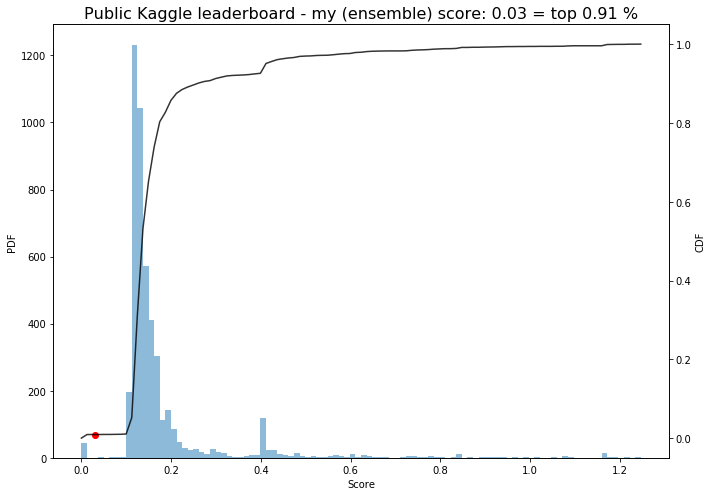

In [ ]:
#hide
my_score_ens = loss_fun(torch.from_numpy(y_pred_ens[:,None]).float(), y_true).item()

show_leaderboard(fname_leaderboard, score_bounds=(None, 1.25), bins=100, user_score=my_score_ens, 
                 user="my (ensemble)")

In [ ]:
#hide
with open("models/ensemble.pckl", "wb") as f:
    pickle.dump(ens, f)